# 1. | Giriş

## Proje Hedefi

Bu notebook'ta, 5 farklı pirinç türünü görsellerinden ayırt edebilen bir derin öğrenme modeli geliştirilecektir. Bu amaçla, Keras kütüphanesi kullanılarak sıfırdan bir **Evrişimli Sinir Ağı (CNN)** modeli oluşturulacak, eğitilecek ve performansı değerlendirilecektir.

## Veri Setine Genel Bakış

Çalışmada, her biri 15,000 adet görüntü içeren 5 farklı pirinç sınıfından oluşan dengeli bir veri seti kullanılmıştır. Görevimiz, bu 75,000 görüntülük veri setini kullanarak pirinç türlerini yüksek doğrulukla sınıflandırabilen bir model tasarlamaktır.

## Sınıflandırılacak Pirinç Türleri

* Arborio
* Basmati
* Ipsala
* Jasmine
* Karacadag

Veri seti hakkında daha fazla bilgi için aşağıdaki Kaggle bağlantısını kullanın:
[Rice Image Dataset](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset)

# 2. | Kütüphanelerin Yüklenmesi ve Veri Setinin Tanımlanması

Bu bölümde, projenin temelini oluşturan adımlar atılmaktadır. İlk olarak, veri analizi (`Pandas`, `NumPy`), görselleştirme (`Matplotlib`, `Seaborn`) ve derin öğrenme modeli (`TensorFlow`, `Keras`) için gerekli olan tüm Python kütüphaneleri çalışma ortamına dahil edilmektedir.

In [1]:
# Kütüphanelerin import edilmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

DATA_DIR = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'

print("Kütüphaneler yüklendi ve veri setinin yolu tanımlandı.")
print("Veri setindeki pirinç türleri (klasörler):", os.listdir(DATA_DIR))

2025-09-24 16:24:49.813171: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758731090.035538      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758731090.100161      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Kütüphaneler yüklendi ve veri setinin yolu tanımlandı.
Veri setindeki pirinç türleri (klasörler): ['Karacadag', 'Basmati', 'Jasmine', 'Rice_Citation_Request.txt', 'Arborio', 'Ipsala']


Kodun son satırı, bu dizine başarıyla erişildiğini ve içerisindeki pirinç türü klasörlerinin doğru bir şekilde listelendiğini doğrular.

## 2.1. | Görüntü Yollarının Okunması ve DataFrame'e Aktarılması

Bu kod, veri setindeki tüm görüntülerin dosya yollarını (filepaths) ve etiketlerini (labels) okur ve bu bilgileri, sonraki adımlarda kolayca işlemek üzere bir pandas DataFrame'i olarak düzenler.

In [2]:
filepaths = []
labels = []

for item in os.listdir(DATA_DIR):
    item_path = os.path.join(DATA_DIR, item)
    
    if os.path.isdir(item_path):
        for file in os.listdir(item_path):
            filepath = os.path.join(item_path, file)
            
            filepaths.append(filepath)
            labels.append(item)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

print("Veri tablosu başarıyla oluşturuldu.")
print(f"Toplam {len(df)} adet resim bulundu.")
df.head()

Veri tablosu başarıyla oluşturuldu.
Toplam 75000 adet resim bulundu.


,filepath,label
0,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
1,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
2,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
3,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag
4,/kaggle/input/rice-image-dataset/Rice_Image_Da...,Karacadag


# 3. | Veri Keşfi ve Görselleştirme (EDA)
Modeli eğitmeden önce veri setini anlamak kritik bir adımdır. Bu hücrede, veri setimizin temel özelliklerini ortaya çıkarmak için iki tür görselleştirme yapılmaktadır.

İlk grafik, her sınıftaki görüntü sayısını göstererek veri setinin dengeli olduğunu doğrular. İkinci görselleştirme ise, modelin öğreneceği veriyi daha iyi anlamak için rastgele pirinç örnekleri sunar.

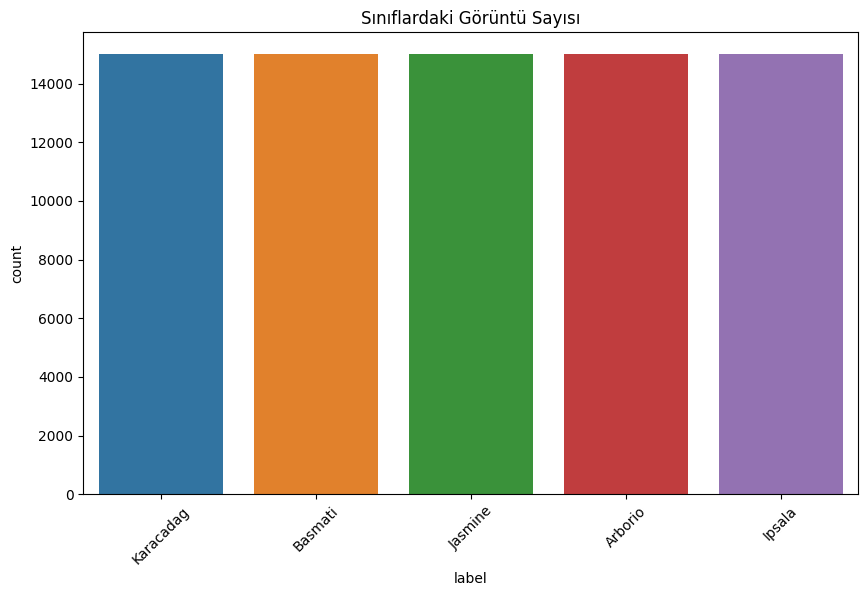

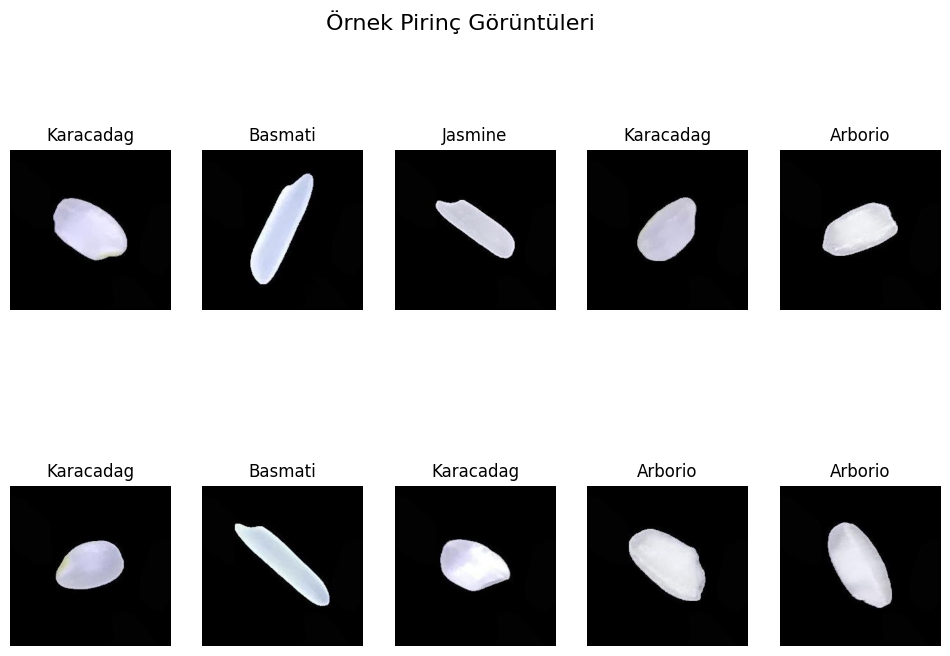

In [3]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.title('Sınıflardaki Görüntü Sayısı')
plt.xticks(rotation=45)
plt.show()

# Birkaç tane örnek pirinç resmi gösterelim
plt.figure(figsize=(12, 8))
for i in range(10):
    # Rastgele bir resim seçiyoruz
    random_index = np.random.randint(0, len(df))
    image_path = df.loc[random_index, 'filepath']
    image_label = df.loc[random_index, 'label']
    
    # Resmi okuyoruz ve gösteriyoruz
    image = plt.imread(image_path)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(image_label)
    plt.axis('off')

plt.suptitle('Örnek Pirinç Görüntüleri', fontsize=16)
plt.show()

# 4. | Veri Setinin Eğitim ve Doğrulama Olarak Ayrılması

Modelin performansını doğru bir şekilde ölçebilmek için, veri setimizi ikiye ayırmamız gerekir: modelin öğrenmek için kullanacağı bir **eğitim seti** ve modelin performansını test etmek için kullanacağı, daha önce hiç görmediği bir **doğrulama seti**.

Bu kod hücresinde, `scikit-learn` kütüphanesinin `train_test_split` fonksiyonu kullanılarak veri setimiz **%80 eğitim** ve **%20 doğrulama** olacak şekilde bölünmektedir. `stratify` parametresi, bu bölme işlemi sırasında her iki sette de beş pirinç türünün orantılı bir şekilde dağılmasını garanti altına alır, bu da modelin daha adil bir şekilde eğitilmesini sağlar.

In [4]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(
    df,
    test_size=0.2,         # %20 validation
    stratify=df['label'],
    random_state=42
)

print(f"Eğitim seti boyutu: {len(train_df)}")
print(f"Doğrulama seti boyutu: {len(valid_df)}")

print("\nEğitim sınıf dağılımı:")
print(train_df['label'].value_counts())

print("\nDoğrulama sınıf dağılımı:")
print(valid_df['label'].value_counts())

Eğitim seti boyutu: 60000
Doğrulama seti boyutu: 15000

Eğitim sınıf dağılımı:
label
Basmati      12000
Ipsala       12000
Karacadag    12000
Arborio      12000
Jasmine      12000
Name: count, dtype: int64

Doğrulama sınıf dağılımı:
label
Arborio      3000
Ipsala       3000
Karacadag    3000
Jasmine      3000
Basmati      3000
Name: count, dtype: int64


## 4.1. | Veri Çoğaltma (Data Augmentation) ve Veri Jeneratörlerinin Oluşturulması

Bu adımda, Keras'ın `ImageDataGenerator` sınıfı kullanılarak **Veri Çoğaltma (Data Augmentation)** işlemi tanımlanmaktadır. Bu işlem, eğitim setindeki her bir görüntüyü alıp, ona rastgele döndürme, yakınlaştırma, kaydırma gibi küçük değişiklikler uygulayarak sanki yeni bir resimmiş gibi modele sunar. Bu, modelin ezber yapmasını (overfitting) engellemenin en etkili yollarından biridir.

Doğrulama seti için ise bu çoğaltma işlemleri uygulanmaz; modelin performansı her zaman orijinal, değiştirilmemiş resimler üzerinde ölçülmelidir.

Son olarak, bu kurallara göre hazırlanan eğitim ve doğrulama DataFrame'leri, `.flow_from_dataframe()` metodu ile modele veri akışı sağlayacak olan **jeneratörlere** dönüştürülür. Bu jeneratörler, veriyi 32'lik gruplar (`batch`) halinde ve `(128, 128)` boyutuna getirilmiş olarak modele verimli bir şekilde sunması amaçlanır.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Piksel değerlerini 0-1 arasına getirir
    rotation_range=20,       # Resimleri rastgele 20 derece döndürür
    width_shift_range=0.2,   # Resimleri yatayda kaydırır
    height_shift_range=0.2,  # Resimleri dikeyde kaydırır
    shear_range=0.2,         # Resimleri eğer
    zoom_range=0.2,          # Resimlere rastgele zoom yapar
    horizontal_flip=True,    # Resimleri yatayda çevirir
    fill_mode='nearest'
)

# Doğrulama verisi için çoğaltma yapmıyoruz, sadece piksel değerlerini 0-1 arasına getiriyoruz
valid_datagen = ImageDataGenerator(
    rescale=1./255
)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False  # validation set sabit kalsın
)

print("Veri generator'ları başarıyla oluşturuldu.")

Found 60000 validated image filenames belonging to 5 classes.
Found 15000 validated image filenames belonging to 5 classes.
Veri generator'ları başarıyla oluşturuldu.


# 5. | Evrişimli Sinir Ağı (CNN) Model Mimarisi

Bu adımda, Keras `Sequential` API'si ile projenin temelini oluşturan CNN modeli katman katman oluşturulmuştur. Model, görüntülerden hiyerarşik özellikler çıkarmak için üç adet `Conv2D` ve `MaxPooling2D` bloğu içerir.

Aşırı öğrenmeyi (overfitting) engellemek ve modelin genelleme yeteneğini artırmak için kritik bir `Dropout` katmanı eklenmiştir. Son olarak, `Flatten` ve `Dense` katmanları ile özellikler işlenir ve 5 sınıflı problemimiz için `softmax` aktivasyonuna sahip bir çıkış katmanı, her pirinç türü için bir olasılık tahmini üretir.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(5, activation='softmax'))

# Modelin mimarisini özet olarak görelim
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-09-24 16:29:10.190185: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 5.1. | Modelin Derlenmesi

Model mimarisi oluşturulduktan sonra, eğitim sürecine hazır hale getirilmesi için **derlenmesi** gerekir. Bu adımda, modele öğrenme sürecinde hangi araçları kullanacağı belirtilir:

- **Optimizer (`adam`):** Modelin, yaptığı hatalardan ders çıkararak ağırlıklarını nasıl güncelleyeceğini belirleyen algoritmadır. `Adam`, çoğu problem için verimli ve etkili bir başlangıç noktasıdır.
- **Loss Fonksiyonu (`categorical_crossentropy`):** Modelin tahminlerinin gerçek değerlerden ne kadar saptığını ölçen matematiksel bir fonksiyondur. Model, eğitim boyunca bu "kayıp" değerini en aza indirmeye çalışır.
- **Metrikler (`accuracy`):** Eğitim ve test sırasında modelin performansını izlemek için kullanılan ölçüttür. Burada, modelin doğru tahmin yapma oranı olan **doğruluk (accuracy)** metriğini takip edeceğiz.

In [7]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model başarıyla derlendi.")

Model başarıyla derlendi.


# 6. | Modelin Akıllı Yardımcılar (Callbacks) ile Eğitilmesi

Bu bölümde model, `model.fit()` fonksiyonu ile hazırlanan veri jeneratörleri kullanılarak eğitilmektedir. Modelin sadece ezber yapmasını engellemek ve en iyi performansı gösteren versiyonunu yakalamak için iki kritik **Callback** (akıllı yardımcı) kullanılmıştır.

1.  **`EarlyStopping`:** Bu yardımcı, modelin doğrulama seti üzerindeki performansını (`val_loss`) her epoch sonunda izler. Performansta belirli bir süre (`patience=5`) boyunca bir iyileşme görmezse, eğitimi otomatik olarak durdurur. Bu, gereksiz yere uzun süren eğitimleri engeller ve modelin en iyi olduğu "zirve anını" kaçırmamasını sağlar. `restore_best_weights=True` parametresi sayesinde, eğitim durduğunda modelin en başarılı olduğu andaki ağırlıkları geri yüklenir.

2.  **`ModelCheckpoint`:** Bu yardımcı da `val_loss` metriğini izler ve sadece bir önceki en iyi skordan daha iyi bir sonuç elde edildiğinde modeli `best_model.keras` adıyla diske kaydeder. Bu, eğitim süreci boyunca elde edilen en iyi modelin her zaman elimizin altında olmasını garanti eder.

Bu iki yardımcı sayesinde model, maksimum 30 epoch'a kadar, aşırı öğrenmeye (overfitting) karşı korunarak ve en iyi performansı hedeflenerek eğitilmiş olur.

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,           # 5 epoch boyunca iyileşme yoksa durur
    restore_best_weights=True
)

# ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)
print("Model başarıyla eğitildi.")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.7492 - loss: 0.5953
Epoch 1: val_loss improved from inf to 0.51888, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1286s 684ms/step - accuracy: 0.7493 - loss: 0.5952 - val_accuracy: 0.8315 - val_loss: 0.5189
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9572 - loss: 0.1174
Epoch 2: val_loss improved from 0.51888 to 0.15927, saving model to best_model.keras
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1105s 589ms/step - accuracy: 0.9572 - loss: 0.1174 - val_accuracy: 0.9395 - val_loss: 0.1593
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 542ms/step - accuracy: 0.9684 - loss: 0.0932
Epoch 3: val_loss did not improve from 0.15927
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1088s 580ms/step - accuracy: 0.9684 - loss: 0.0932 - val_accuracy: 0.7496 - val_loss: 1.2062
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - accuracy: 0.9740 - loss: 0.0762
Epoch 4: val_loss improved from 0.15927 to 0.03620, sav

## 6.1. | Modelin Öğrenme Sürecinin Görselleştirilmesi

Bu adımda, modelin eğitim süreci boyunca kaydettiği doğruluk (`accuracy`) ve kayıp (`loss`) metrikleri görselleştirilir. Çizdirilen bu grafikler, eğitim ve doğrulama eğrilerinin seyrini göstererek modelin öğrenme performansını ve olası bir aşırı öğrenme (overfitting) durumunu hızlıca analiz etmemizi sağlar.

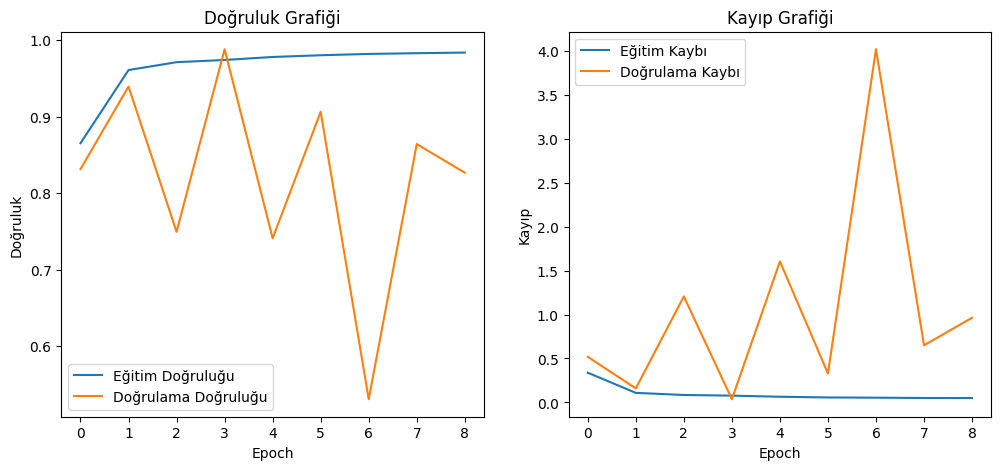

In [9]:
hist_df = pd.DataFrame(history.history)

# Doğruluk (Accuracy) grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_df['accuracy'], label='Eğitim Doğruluğu')
plt.plot(hist_df['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

# Kayıp (Loss) grafiği
plt.subplot(1, 2, 2)
plt.plot(hist_df['loss'], label='Eğitim Kaybı')
plt.plot(hist_df['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Grafiği')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.show()

## 6.2. | Model Performansının Detaylı Değerlendirilmesi

Bu adımda, eğitimde kaydedilen en iyi model (`best_model.keras`) dosyadan geri yüklenerek performansı analiz edilir. Bu yöntem, sonuçların her zaman modelin en başarılı versiyonuna ait olmasını garanti eder.

Bu yüklenmiş model ile doğrulama seti üzerinde tahminler yapılarak iki önemli çıktı üretilir: Her sınıfın başarısını detaylandıran **Sınıflandırma Raporu (Classification Report)** ve modelin yaptığı hataları görselleştiren **Karışıklık Matrisi (Confusion Matrix)**. Bu metrikler, modelin genel doğruluğunu ve hangi sınıflarda zorlandığını net bir şekilde görmemizi sağlar.

Kaydedilmiş en iyi model olan 'best_model.keras' yükleniyor...
Model başarıyla yüklendi.
469/469 ━━━━━━━━━━━━━━━━━━━━ 69s 147ms/step

Classification Report

              precision    recall  f1-score   support

     Arborio       0.98      0.98      0.98      3000
     Basmati       1.00      0.98      0.99      3000
      Ipsala       0.99      1.00      1.00      3000
     Jasmine       0.97      1.00      0.98      3000
   Karacadag       1.00      0.98      0.99      3000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



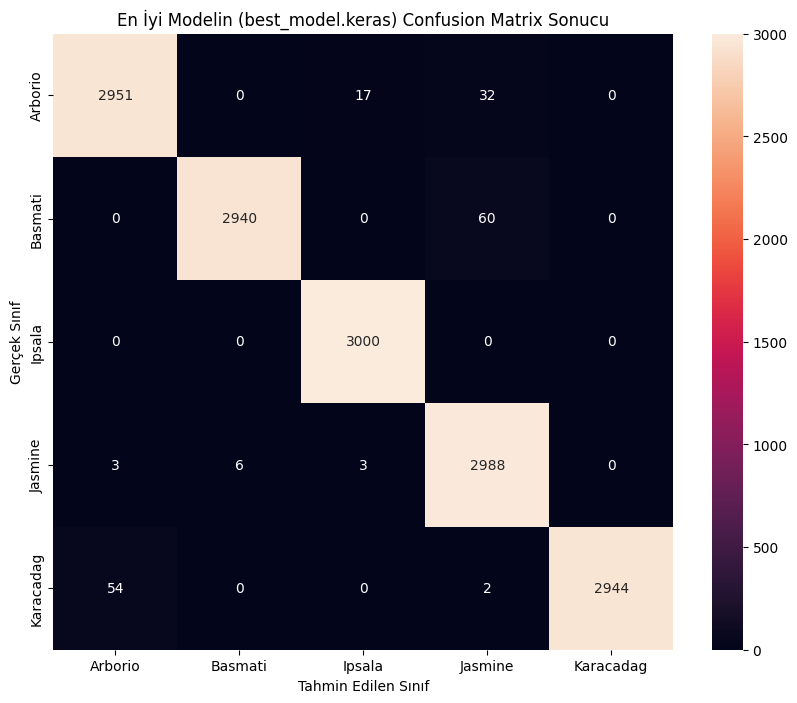

In [10]:
from tensorflow.keras.models import load_model # <-- Kütüphaneyi ekliyoruz
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print("Kaydedilmiş en iyi model olan 'best_model.keras' yükleniyor...")
best_model = load_model('best_model.keras')
print("Model başarıyla yüklendi.")

steps = int(np.ceil(valid_generator.n / BATCH_SIZE))

predictions = best_model.predict(valid_generator, steps=steps)


predicted_classes = np.argmax(predictions, axis=1)

true_classes = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())

print("\nClassification Report\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

cm = confusion_matrix(true_classes, predicted_classes)

# Confusion Matrix'i görselleştiriyoruz
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
plt.title('En İyi Modelin (best_model.keras) Confusion Matrix Sonucu')
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.show()

# 7. | Sonuç ve Değerlendirme

Bu projede amacım, 75,000 görüntüden oluşan "Rice Image Dataset"ini kullanarak beş farklı pirinç türünü ayırt edebilen yüksek performanslı bir CNN modeli geliştirmekti.

Proje boyunca, veri hazırlama, veri çoğaltma (data augmentation) ve katman katman bir CNN mimarisi kurma gibi derin öğrenmenin temel adımlarını uyguladım. Eğitim aşamasında en çok odaklandığım konulardan biri, modelin ezber yapmasını (overfitting) engellemekti. Bu sorunun önüne geçmek için `EarlyStopping` gibi akıllı yardımcılar (callbacks) kullandım ve bu sayede modelin en verimli noktada durmasını sağladım.

Bu yaklaşımım sonucunda, modelim daha önce görmediği doğrulama verileri üzerinde **%99 gibi oldukça başarılı bir doğruluk oranına ulaştı.** Ayrıca, Grad-CAM analizi ile modelimin sadece doğru tahmin yapmakla kalmayıp, karar verirken mantıklı bir şekilde pirinç tanelerinin kendisine odaklandığını da teyit ettim.

 Bu proje, benim için baştan sona bir derin öğrenme projesinin nasıl hayata geçirileceğini gösteren değerli bir tecrübe oldu.